In [88]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import unicodedata, re, string
import nltk
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import os
print(os.listdir("/home/xiyu/data/trainee/ZhuYanru"))

['.vector_cache', 'TextClassification2.py', '未命名1.ipynb', '.ipynb_checkpoints', 'Task2LstmByIdf.ipynb', 'Task2LstmByWordidx.ipynb', 'Task2TorchText.ipynb', 'train.tsv', 'TextClassification.py', 'test.tsv', 'Task1.ipynb']


In [89]:
df_train = pd.read_csv("/home/xiyu/data/trainee/ZhuYanru/train.tsv", sep="\t")
df_test = pd.read_csv("/home/xiyu/data/trainee/ZhuYanru/test.tsv", sep="\t")

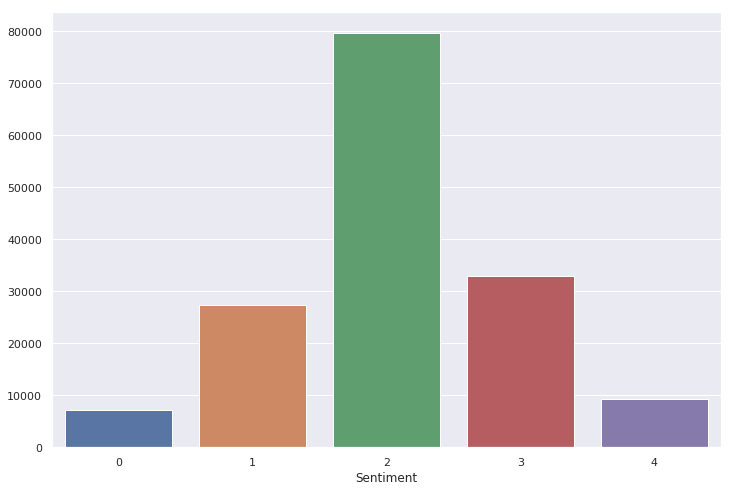

In [63]:
#df_train.info()
#df_train.head()
#df_train.loc[df_train['SentenceId'] == 1]
dist = df_train.groupby(["Sentiment"]).size()
#dist = dist / dist.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [90]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    #print(len(words))
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    #print(len(new_words))
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words
def convert_to_onehot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [91]:
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

In [92]:
# Third step - creating a list of unique words to be used as dictionary for encoding
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}
#句子id-当前句子总词频
sentence_word_count_dic=[]
#词-文档数
Doc_word_dic={}
for phrase in df_train['Words']:
    sentence_word={}
    #词-词频（当前句子）
    for word in phrase:
        if word not in sentence_word.keys():
            sentence_word[word]=1
        else:
            sentence_word[word]+=1
    sentence_word_count_dic.append([len(phrase),sentence_word])
    #词-文档数
    for setword in sentence_word.keys():
        if setword not in Doc_word_dic.keys():
            Doc_word_dic[setword]=1
        else:
            Doc_word_dic[setword]+=1
            
#print(sentence_word_count_dic[0])
doc_idf=[]
for line in sentence_word_count_dic:
    sentence_idf={}
    for word,count in  line[1].items():
        idf=(count/line[0])*(math.log(int(len(df_train['Words'])))/Doc_word_dic[word])
        sentence_idf[word]=idf
    doc_idf.append(sentence_idf)

print(doc_idf[:10])


[{'a': 2.1989896611169193e-05, 'series': 0.000943803932728552, 'of': 4.9095706803813153e-05, 'escapades': 0.06833140472954714, 'demonstrating': 0.017981948613038725, 'the': 2.5864166921779687e-05, 'adage': 0.020097471979278574, 'that': 2.9534666636215057e-05, 'what': 0.00018649400854134045, 'is': 5.40981749105749e-05, 'good': 0.00034423881475842394, 'for': 9.692397833978319e-05, 'goose': 0.010048735989639287, 'also': 0.0005216137765614286, 'gander': 0.03796189151641508, 'some': 0.0002064392892131334, 'which': 0.0005080401838628041, 'occasionally': 0.0018568316502594335, 'amuses': 0.03416570236477357, 'but': 6.717597790950369e-05, 'none': 0.0017611186785965762, 'amounts': 0.005694283727462263, 'to': 1.727459923388289e-05, 'much': 0.00018438047687411536, 'story': 0.0001364990106463187}, {'a': 2.748737076396149e-05, 'series': 0.0023595098318213797, 'of': 3.068481675238322e-05, 'escapades': 0.17082851182386785, 'demonstrating': 0.044954871532596814, 'the': 4.310694486963281e-05, 'adage': 0

In [123]:
df_train['tfidf'] = df_train['Words'].apply(lambda l:[])

for row_id in range(0,len(df_train['Words'])):
    #print(df_train['Words'][row_id])
    for word in  df_train['Words'][row_id]:
        df_train['tfidf'][row_id].append([word_to_int[word],doc_idf[row_id][word]])
df_train['tfidf'].head()

0    [[10214, 2.1989896611169193e-05], [8844, 0.000...
1    [[10214, 2.748737076396149e-05], [8844, 0.0023...
2    [[10214, 0.00019241159534773045], [8844, 0.016...
3                     [[10214, 0.0003848231906954609]]
4                        [[8844, 0.03303313764549932]]
Name: tfidf, dtype: object

In [124]:
#df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
#df_train['Tokens'].head()
max_len = df_train['tfidf'].str.len().max()
print(max_len)
#df_train['tfidf'].head()

48


In [139]:
# Pad each phrase representation with zeroes, starting from the beginning of sequence
# Will use a combined list of phrases as np array for further work. This is expected format for the Pytorch utils to be used later

all_tokens = np.array([t for t in df_train['tfidf']])
encoded_labels = np.array([l for l in df_train['Sentiment']])
#print(all_tokens[:3])
# Create blank rows
features = np.zeros((len(all_tokens), max_len,2), dtype=float)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    for j in range(0,len(row)):
        #print(row[j])
        features[i,j][0] = row[j][0]
        features[i,j][1] = row[j][1]
    #print(features[i, :len(row)])
#print first 3 values of the feature matrix 
print(features[:3])

[[[1.02140000e+04 2.19898966e-05]
  [8.84400000e+03 9.43803933e-04]
  [8.13400000e+03 4.90957068e-05]
  [1.31170000e+04 6.83314047e-02]
  [9.60000000e+02 1.79819486e-02]
  [4.98700000e+03 2.58641669e-05]
  [1.05960000e+04 2.00974720e-02]
  [1.31040000e+04 2.95346666e-05]
  [1.14640000e+04 1.86494009e-04]
  [6.90400000e+03 5.40981749e-05]
  [4.61800000e+03 3.44238815e-04]
  [1.14250000e+04 9.69239783e-05]
  [4.98700000e+03 2.58641669e-05]
  [1.56220000e+04 1.00487360e-02]
  [6.90400000e+03 5.40981749e-05]
  [1.24770000e+04 5.21613777e-04]
  [4.61800000e+03 3.44238815e-04]
  [1.14250000e+04 9.69239783e-05]
  [4.98700000e+03 2.58641669e-05]
  [3.16600000e+03 3.79618915e-02]
  [3.59900000e+03 2.06439289e-04]
  [8.13400000e+03 4.90957068e-05]
  [4.19100000e+03 5.08040184e-04]
  [8.08400000e+03 1.85683165e-03]
  [1.10280000e+04 3.41657024e-02]
  [8.03700000e+03 6.71759779e-05]
  [1.28780000e+04 1.76111868e-03]
  [8.13400000e+03 4.90957068e-05]
  [4.19100000e+03 5.08040184e-04]
  [1.47380000e

In [140]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 48, 2) 
Validation set: 	(15606, 48, 2) 
Test set: 		(15606, 48, 2)


In [154]:
# create Tensor datasets

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 54

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Check the size of the loaders (how many batches inside)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))


2312
289
289


In [147]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [148]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        print(batch_size)
        # embeddings and lstm_out
        #embeds = self.embedding(x.squeeze(1).long())
        
        #embeds = x.squeeze(1).long()
        embeds = x
        lstm_out, hidden = self.lstm(embeds, hidden)

        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [149]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 5
embedding_dim = 48
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

SentimentRNN(
  (lstm): LSTM(48, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [155]:
epochs = 3 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            #print(inputs)
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()
        print(inputs)
        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        #print(labels.long())
        loss = criterion(output, labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels.long())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

tensor([[[4.6450e+03, 1.1724e-01],
         [1.4189e+04, 7.1691e-03],
         [1.0214e+04, 6.4137e-05],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.2670e+03, 2.7575e-04],
         [1.1081e+04, 2.8471e-02],
         [1.3247e+04, 4.0307e-05],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.4760e+03, 9.3715e-03],
         [3.1050e+03, 1.5940e-03],
         [0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        ...,

        [[4.8750e+03, 5.1991e-01],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.5778e+04, 1.9526e-03],
         [6.5900e+03, 2.7177e-01],
         [0.

RuntimeError: input.size(-1) must be equal to input_size. Expected 48, got 2

In [86]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))


Test loss: 1.309
Test accuracy: 0.488


In [33]:
print(train_x.shape)

(124848, 48)
